# Metrics III - Exercise class 3

This notebook contains the coding material for the third TA-session of the PhD core course Statistics and Econometrics 3, part 1 (EUI, 2025). 

*Any errors are my own, in case of conflicts always follow the [course material](https://jesusbueren.github.io/teaching/)
 provided.*

Questions can be asked during TA-sessions, office hours, or by email. 

**TA-Sessions**

- 07-02-2025 at 14:00
- 12-02-2025 at 14:00
- 20-02-2025 at 14:00

**Office hours**

- Tuesday 18-02; 09:00-11:00

**PS submission guidelines + general remarks**

Please submit **one** file, containing text, code, calculations. (Think RMarkdown, Jupyter Notebook, Overleaf with minted environment appendix with code).

Try to code from scratch, and not to use built-in functions. Try to write your own functions. 

## Reduced form VAR

Let's look at a simple example for the components asked in the exercises: 

1) Granger "Causality"
2) IRFs
3) Error bands for the IRF

VAR: 

### Simulate data

$$
\begin{bmatrix}
x_t \\
z_t
\end{bmatrix}
=
\begin{bmatrix}
0.4 & -0.1 \\
0.2 & 0.3
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
z_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{x,t} \\
\epsilon_{z,t}
\end{bmatrix}
$$

With $\epsilon_t \sim N(0, \Omega)$, and $\Omega = \begin{bmatrix}
1 & 0.1 \\
0.1 & 1
\end{bmatrix}$

In [1]:
# Dependencies 
library(tidyverse)
library(ggplot2)
library(patchwork)

# Seed for reproducability 
set.seed(42)
n <- 500

# Simulate data
omega <- matrix(c(1, 0.1, 1, 0.1), nrow=2)
fmat <- matrix(c(0.4, -0.1, 0.2, 0.3), nrow=2)

# Draw errors from a multivariate normal
errs <- MASS::mvrnorm(n=(n+1), mu=c(0,0), Sigma = omega) 

# Data frame to store all data
df <- data.frame(errs)%>%
  rename(ex = X1, ez = X2)%>%
  mutate(x=0, z=0, time=0:(nrow(.)-1))

# Using the equations
for (i in 2:nrow(df)){
  
  df[i, "x"] = fmat[1,1]*df[i - 1, "x"] + fmat[1,2]*df[i - 1, "z"] + df[i, "ex"]
  df[i, "z"] = fmat[2,1]*df[i - 1, "x"] + fmat[2,2]*df[i - 1, "z"] + df[i, "ez"]

}

# Remove initial value
df <- df[-1,]

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


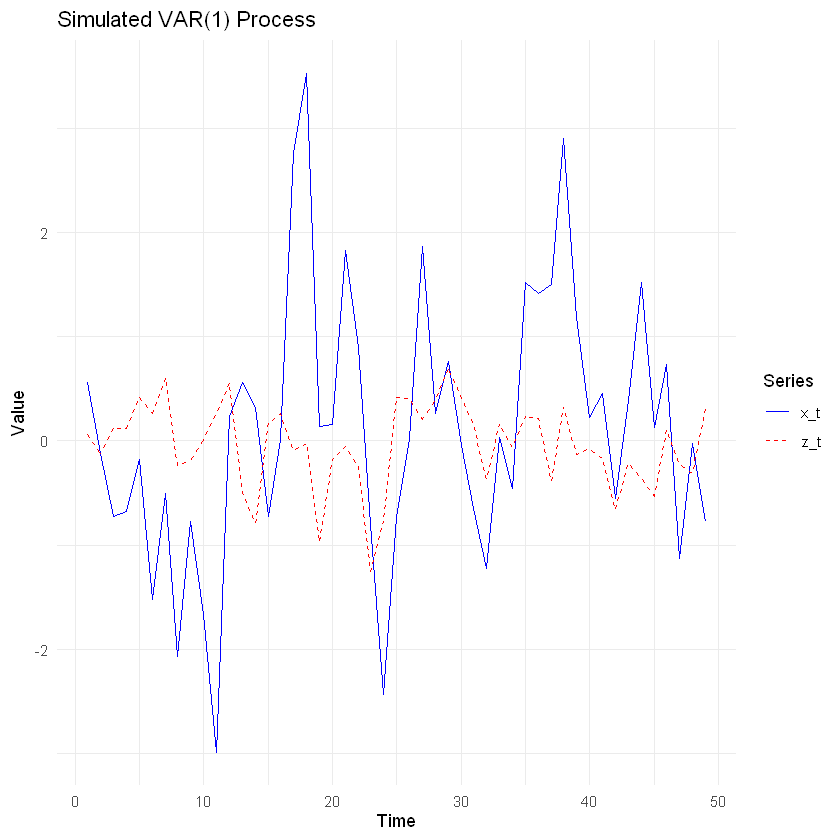

In [2]:
# Plot the series:
df%>%
filter(time < 0.1*n)%>%
ggplot(aes(x = time)) +
  geom_line(aes(y = x, color = "x_t")) +
  geom_line(aes(y = z, color = "z_t"), linetype = "dashed") +
  labs(title = "Simulated VAR(1) Process", x = "Time", y = "Value") +
  scale_color_manual(name = "Series", values = c("x_t" = "blue", "z_t" = "red")) +
  theme_minimal()

### Granger Causality

Let's just check it out for one series. Specifically, let's see if $z_t$ helps to predict $x_t$:

In [3]:
# Add lags to the dataframe
df <- df%>%
  mutate(
    lag_x = lag(x, n=1), 
    lag_z = lag(z, n=1)
  )%>%
  slice_tail(n=-1)

# Estimate the unrestricted model: 
ur <- lm(x ~ lag_x + lag_z - 1, data=df)
print(ur) # not too close to the top row of the fmat... Samples!!!

# Estimate the restricted model phi_12 = 0
r <- lm(x ~ lag_x - 1, data=df)
print(r)


Call:
lm(formula = x ~ lag_x + lag_z - 1, data = df)

Coefficients:
 lag_x   lag_z  
0.3677  0.2452  


Call:
lm(formula = x ~ lag_x - 1, data = df)

Coefficients:
 lag_x  
0.3789  



In [4]:
# Get the sum of squared residuals (SSR)
ssr_ur <- sum((ur$residuals)^2)
ssr_r <- sum((r$residuals)^2)

# F-test (model without constant): (n-k-1)=(T - p), One restriction: q=1
T <- nrow(df) 
ftest <- (T - 1)*((ssr_r - ssr_ur) / ssr_ur)

# F-test follows chi^2 distribution: 
pval <- 1 - pchisq(ftest, 1)
print(pval) 

[1] 0.04970051


### IRF

To get the theoretical IRF, we shock one of the errors. Let's shock $\epsilon_{x,0} = 1$. All other errors are set to zero. Note that in contrast to what we had in the first part of the course, the shock will now propagate to the other variable as well. This means one shock generates an IRF for both $x$ and $z$. 

First, using simulation:

In [5]:
# Initialize empty data frame up to window T to store IRFs (keep it throughout the notebook)
window <- 10

# Empty data frame 
irfs_empty <- data.frame(
  "irfx" = c(0, rep(0, window-1)), 
  "irfz" = c(0, rep(0, window-1)) 
)

# To get quick plots: 
irf_plot <- function(data, variable){
  p <- data%>%
    mutate(time = row_number())%>%
    ggplot(aes(x = time))+
    geom_line(aes(y = !!sym(variable)), color="blue")+
    labs(
      title = glue::glue("Impulse Response Function (IRF): {variable}"), 
      x = "Time", 
      y = "Response"
    ) +
    theme_light()
  return(p)
}

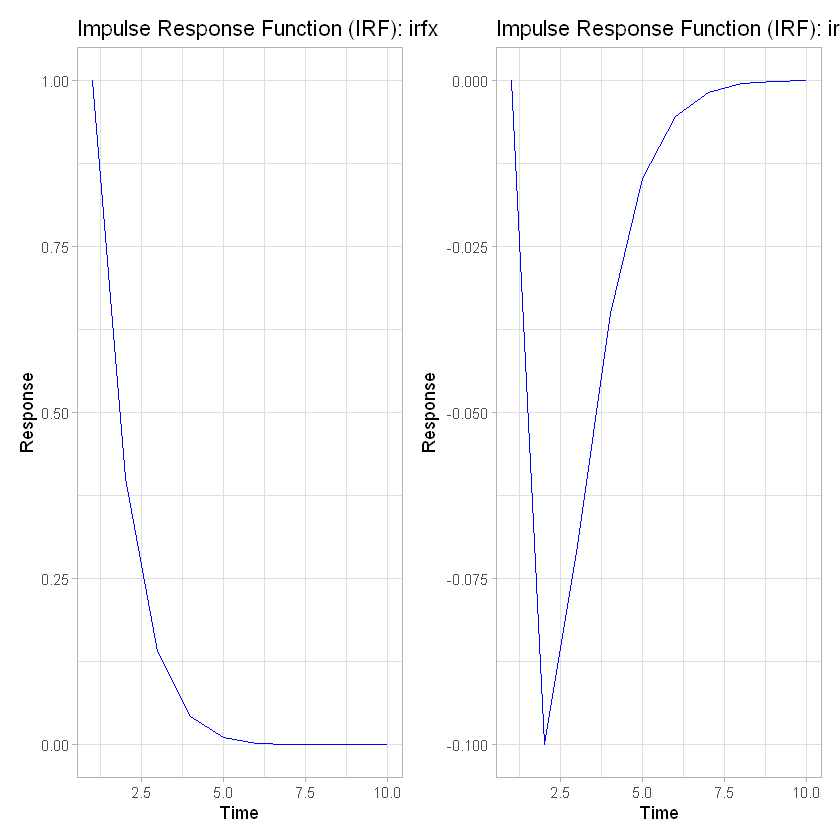

In [6]:
# Copy empty irf storage dataframe
irfs <- irfs_empty
irfs[1, "irfx"] = 1

# Loop over the next periods
for (i in 2:window){

    irfs[i, "irfx"] = fmat[1,1]*irfs[i - 1, "irfx"] + fmat[1,2]*irfs[i - 1, "irfz"]
    irfs[i, "irfz"] = fmat[2,1]*irfs[i - 1, "irfx"] + fmat[2,2]*irfs[i - 1, "irfz"]

    # OR leave it as matrix algebra (cleaner): irfs[i, ] = t(fmat %*% t(irfs[i - 1,]))
}

# Plot the IRF
p1 <- irf_plot(irfs, "irfx")
p2 <- irf_plot(irfs, "irfz")

p1+p2

In [7]:
# Construct companion matrix
F <- cbind(rbind(fmat, diag(x = 2)), matrix(0, nrow=4, ncol=2))
print(F)

     [,1] [,2] [,3] [,4]
[1,]  0.4  0.2    0    0
[2,] -0.1  0.3    0    0
[3,]  1.0  0.0    0    0
[4,]  0.0  1.0    0    0


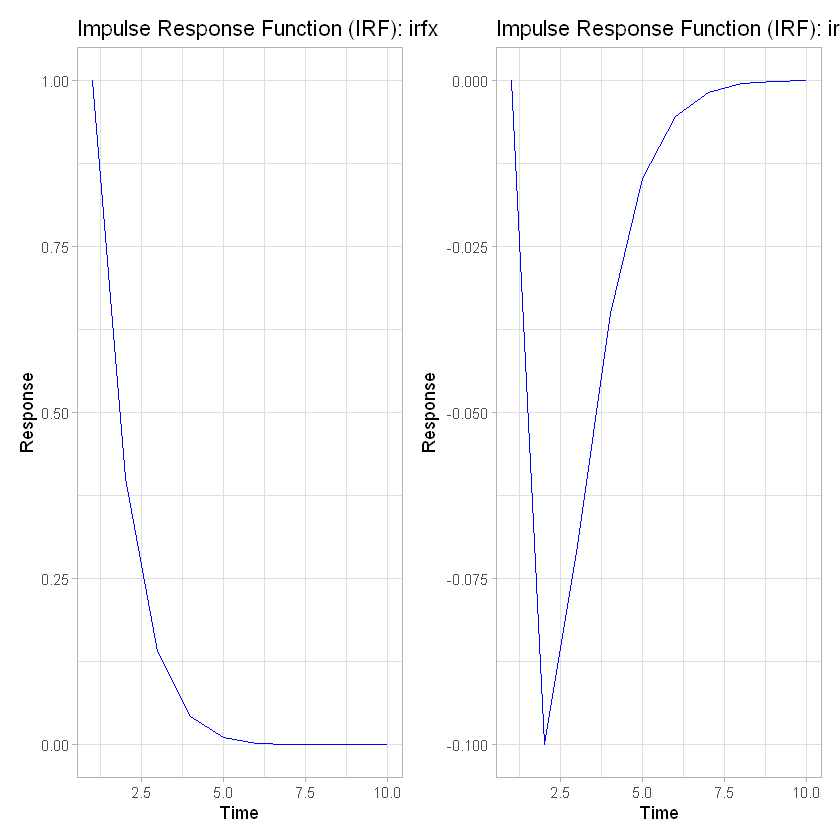

In [8]:
# Frame for the shocks
irfs <- irfs_empty
irfs[1, "irfx"] = 1

# Iterate over F:
F_n <- F^1 # gives just phi_1

# Fill df with the IRFs 
for (i in 2:window){

    if (i > 2){
        F_n <- F_n %*% F
    }

    irfs[i, "irfx"] = F_n[1,1]
    irfs[i, "irfz"] = F_n[2,1]
    
}

# Plot the IRF
p1 <- irf_plot(irfs, "irfx")
p2 <- irf_plot(irfs, "irfz")

p1+p2

### Error bands

We already saw that the coefficients estimated for the F-test were not exactly the same as the ones we used to generate the sample. Therefore we want to add error bands to the IRFs. 

Let's follow the steps from the slides to get error bands. Basically, we want to combine all the steps we did before, and then loop over them M times. Finally, of those M draws, you want to calculate the upper 97.5 and lower 2.5 percentiles (I leave the last two steps up to you). 

In [9]:
# Step 1: Estimate the VAR, save the errors and matrix of coefficients
modx <- lm(x ~ lag_x + lag_z - 1, data=df)
modz <- lm(z ~ lag_x + lag_z - 1, data=df)

# Save estimated matrix of coefficients 
fmat_est <- rbind(modx$coefficients, modz$coefficients)

# Different from the true one? 
print(fmat_est)

          lag_x     lag_z
[1,]  0.3676775 0.2452482
[2,] -0.1046601 0.3178025


In [10]:
# Save the errors
df_errs <- data.frame(
  "res_x" = modx$residuals, 
  "res_z" = modz$residuals
)

In [11]:
# Step 2: Draw a sample from these errors with replacement
t <- 100 # sample size bootstrap

e_boot <- df_errs[sample(nrow(df_errs), t+1, replace = TRUE), ]

# Create simulated sample with these errors
df_sim <- data.frame("x"=rep(0, t+1), "z"=rep(0, t+1))

# Using the equations
for (i in 2:nrow(df_sim)){
    
  df_sim[i,] = t(fmat %*% t(df_sim[i - 1,]) + e_boot[i,])
}

# Remove initial value
df_sim <- df_sim[-1,]

# Add lagged values
df_sim <- df_sim%>%
  mutate(
    lag_x = lag(x, n=1), 
    lag_z = lag(z, n=1)
  )%>%
  slice_tail(n=-1)

In [12]:
# Step 3: Estimate new matrix of coefficients and use for IRF:
modx_hat <- lm(x ~ lag_x + lag_z - 1, data=df_sim)
modz_hat <- lm(z ~ lag_x + lag_z - 1, data=df_sim)

# Save estimated matrix of coefficients 
fmat_est <- rbind(modx_hat$coefficients, modz_hat$coefficients)
print(fmat_est)

          lag_x     lag_z
[1,]  0.3676775 0.2452482
[2,] -0.1046601 0.3178025


In [13]:
# Get the IRFs using this matrix of coefficients

# Frame for the shocks
irf_iter_x <- irfs_empty
irf_iter_z <- irfs_empty

irf_iter_x[1, "irfx"] = 1
irf_iter_z[1, "irfz"] = 1

# Construct companion matrix
F <- cbind(rbind(fmat_est, diag(x = 2)), matrix(0, nrow=4, ncol=2))

# Iterate over F:
F_n <- F^1 

# Fill df with the IRFs 
for (i in 2:window){

    if (i > 2){
        F_n <- F_n %*% F
    }

    irf_iter_x[i, "irfx"] = F_n[1,1]
    irf_iter_x[i, "irfz"] = F_n[2,1]
    irf_iter_z[i, "irfx"] = F_n[1,2]
    irf_iter_z[i, "irfz"] = F_n[2,2]
    
}

head(irf_iter_x)
head(irf_iter_z)

# Step 4: Repeat the above steps M times and calculate CIs

,irfx,irfz
,<dbl>,<dbl>
1,1.000000e+00,0.000000000
2,3.676775e-01,-0.104660064
3,1.095191e-01,-0.071742376
4,2.267301e-02,-0.034262175
5,-6.638164e-05,-0.013261561
6,-3.276781e-03,-0.004207609


,irfx,irfz
,<dbl>,<dbl>
1,0.000000000,1.000000000
2,0.245248190,0.317802451
3,0.168112719,0.075330706
4,0.080285985,0.006345595
5,0.031075597,-0.006386091
6,0.009859621,-0.005281889


### Cholesky decomposition

So what when we instead want to look at structural VARs? Make sure you order your equations in such a way that they align with the identifying assumptions you have made (which you draw based on economic intuition). To get the $B_0^{-1}$:

In [14]:
# First, get the covariance matrix (Omega)
e <- cbind(modx$residuals, modz$residuals)
omega <- cov(e)

# Get b0^{-1}
P <- t(chol(omega))
D <- diag(diag(P))
b0inv <- P%*%solve(D)